# W207 Final Project - Predicting Bike Share Demand
## Introduction to Machine Learning - Fall 2017 - Section 1 

### Vicki Foss, Noah Levy, Amy Smessaert

Project: https://www.kaggle.com/c/bike-sharing-demand

## A. Introduction  
Our purpose for this project is to predict the total number of bikeshare rentals in Washington, D.C., given a previously unseen date and hour from 2011-2012.  

Similar to programs in other cities, D.C.'s Capital Bikeshare program allows registered users to check out a bike from any bike station and to return it to any of the other stations in the city. Similarly, non-registered or "casual" users may also pay a one-time or daily fee to check out bikes in the system. 
In the labeled dataset we will be using to create our model, the total number of check-outs or "rentals" is aggregated by hour for each type of user (registered and casual) and explicity recorded, along with weather data for that particular day and hour. The following excerpt from [Kaggle](https://www.kaggle.com/c/bike-sharing-demand/data) provides more information about each field in the dataset: 

> You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.  

> <pre-wrap>
<h3>Data Fields</h3>  
<b>datetime</b> - hourly date + timestamp  
<b>season</b> -  1 = spring, 2 = summer, 3 = fall, 4 = winter   
<b>holiday</b> - whether the day is considered a holiday  
<b>workingday</b> - whether the day is neither a weekend nor holiday  
<b>weather</b> - 1: Clear, Few clouds, Partly cloudy, Partly cloudy  
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds   
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog  
<b>temp</b> - temperature in Celsius  
<b>atemp</b> - "feels like" temperature in Celsius  
<b>humidity</b> - relative humidity  
<b>windspeed</b> - wind speed  
<b>casual</b> - number of non-registered user rentals initiated  
<b>registered</b> - number of registered user rentals initiated  
<b>count</b> - number of total rentals</pre-wrap>

_Note that the last three fields on this list (casual, registered, count) are not included in the test data. This is because our objective is to predict the "count" column of the test data (which is a sum of the registered and non-registered users)._

Following an exploratory data analysis, our approach will be to do some feature engineering--which will incorporate results from the exploratory analysis--and then further partition our training data into training and development data, which we will use to build and test various machine learning models for predicting the hourly counts of rentals by registered and non-registered users. Our goal is reduce the Root Mean Squared Logarithmic Error (RMSLE) of our predicted counts as much as possible.

<br>

## B. Load the Bikeshare Data

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline
plt.style.use('ggplot')

pd.options.display.max_columns = 999


In [2]:
# Download data from https://www.kaggle.com/c/bike-sharing-demand/data/ 
# and place the files "train.csv" and "test.csv" in the same directory
# as the file for this Jupyter notebook.

train = pd.read_csv('train.csv', parse_dates=[0])
test = pd.read_csv('test.csv', parse_dates=[0])

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.6 KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
datetime      6493 non-null datetime64[ns]
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 456.6 KB


In [5]:
# Clean up training data for the EDA:

# Add additional variables by partitioning the "datetime" column:
train['day_of_week'] = train['datetime'].apply(lambda x: x.strftime('%A'))
train['day_of_week'] = pd.Categorical(train['day_of_week'], 
    categories=['Sunday','Monday','Tuesday','Wednesday','Thursday',
    'Friday','Saturday'], ordered=True)
train['hour'] = train['datetime'].apply(lambda x: x.strftime('%H'))
train['month'] = train['datetime'].apply(lambda x: x.strftime('%B'))
train['month'] = pd.Categorical(train['month'], categories=[
    'January', 'February', 'March', 'April', 'May', 'June', 'July', 
    'August', 'September', 'October', 'November', 'December'],
    ordered=True)
train['year'] = train['datetime'].apply(lambda x: x.strftime('%Y'))

# Create season/weather variables
season={1:'Spring',2:'Summer',3:'Fall',4:'Winter'}
train['season'] = train['season'].map(season)
train['season'] = pd.Categorical(train['season'],
    categories=['Spring', 'Summer', 'Fall', 'Winter'], ordered=True)
weather = {1: 'Clear', 2: 'Misty', 3: 'LightPrecip', 4: 'HeavyPrecip'}
train['weather'] = train['weather'].map(weather)
train['weather'] = pd.Categorical(train['weather'],
    categories=['Clear', 'Misty', 'LightPrecip', 'HeavyPrecip'], ordered=True)

In [6]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,day_of_week,hour,month,year
0,2011-01-01 00:00:00,Spring,0,0,Clear,9.84,14.395,81,0.0,3,13,16,Saturday,00,January,2011
1,2011-01-01 01:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,8,32,40,Saturday,01,January,2011
2,2011-01-01 02:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,5,27,32,Saturday,02,January,2011
3,2011-01-01 03:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,3,10,13,Saturday,03,January,2011
4,2011-01-01 04:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,0,1,1,Saturday,04,January,2011


## C. Exploratory Data Analysis

In [7]:
# Statistical summary of columns of training data (and labels) not dependent on date/time

train[train.columns[2:12]].describe(include='all')

,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
unique,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Clear,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,7192,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.028569,0.680875,NaN,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,0.166599,0.466159,NaN,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,0.000000,0.000000,NaN,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,NaN,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,0.000000,1.000000,NaN,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,0.000000,1.000000,NaN,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000


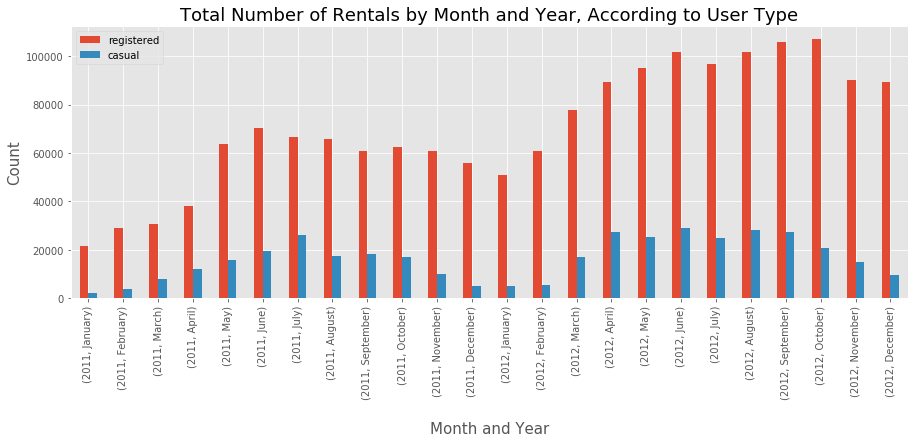

In [8]:
train[['month','year','registered','casual']].groupby(['year', 'month']).sum()\
    .plot(kind="bar", figsize=(15,5))
plt.ylabel("Count", size=15)
plt.xlabel("\nMonth and Year", size=15)
plt.title("Total Number of Rentals by Month and Year, According to User Type", size=18)
plt.show()

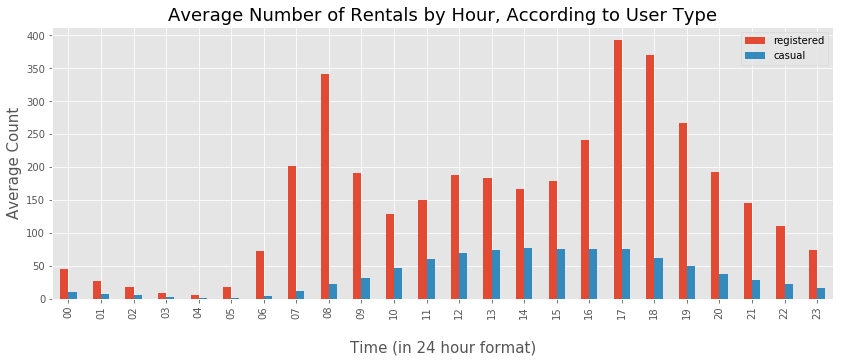

In [9]:
train[["hour","registered","casual"]].groupby("hour").mean()\
    .plot(kind="bar", figsize=(14,5)).set_ylabel("Average Count", size=15)
plt.xlabel("\nTime (in 24 hour format)", size=15)
plt.title("Average Number of Rentals by Hour, According to User Type", size=18)
plt.show()    

Peak times for registered and casual users are the opposite: registered users' peek rental times are during the 8:00 morning hour and the 5, 6, and 7 o'clock pm hours (corresponding to before and after typical work schedules). Casual users tend to rent more between 1 and 5pm.  

On non-working days, the patterns are very different for both user types:

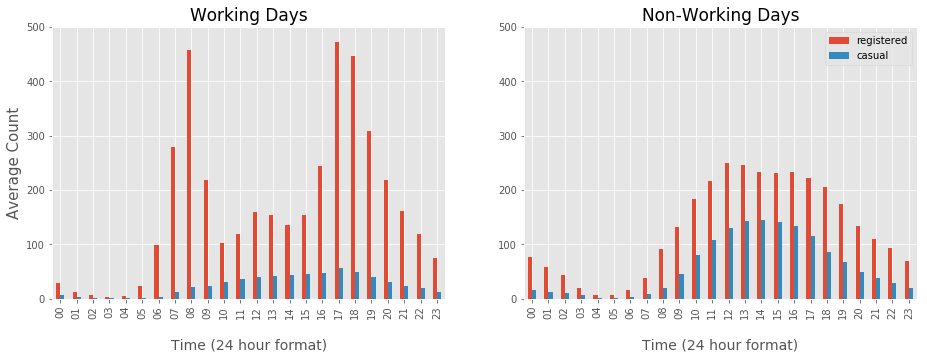

In [10]:
train_work = train[train['workingday']==1]
train_nonwork = train[train['workingday']==0]

plt.subplots(nrows=1, ncols=2, figsize=(15.5,5))
plt.subplots_adjust(right=None, wspace=None, left=None)
plt.subplot(1,2,1)
train_work[['hour','registered','casual']].groupby('hour').mean()\
    .plot(kind="bar", ax=plt.gca(), ylim=(0,500), legend=None)
plt.xlabel("\nTime (24 hour format)", size=14)
plt.ylabel("Average Count", size=15)
plt.title('Working Days', size=17)

plt.subplot(1,2,2)   
train_nonwork[['hour','registered','casual']].groupby('hour').mean()\
    .plot(kind="bar", ax=plt.gca(), ylim=(0,500))
plt.xlabel("\nTime (24 hour format)", size=14)
plt.title('Non-Working Days', size=17)

plt.show()

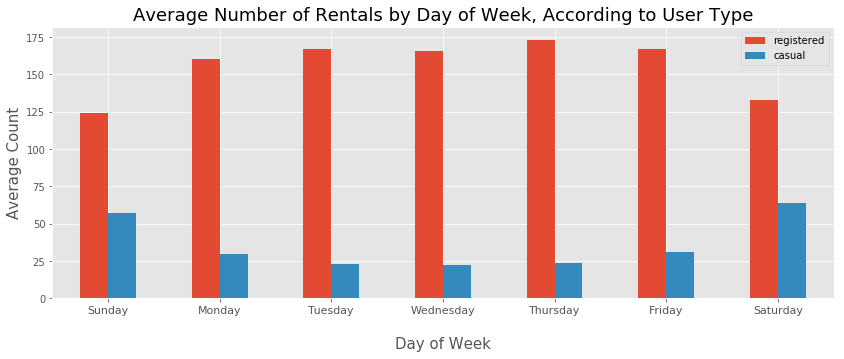

In [11]:
train[['day_of_week','registered','casual']].groupby('day_of_week').mean().sort_index()\
    .plot(kind="bar", figsize=(14,5))
plt.xticks(rotation=0, size=11)
plt.ylabel("Average Count", size=15)
plt.xlabel("\nDay of Week", size=15)
plt.title("Average Number of Rentals by Day of Week, According to User Type", size=18)
plt.show()

Again we see a difference: casual users rent more on weekends; registered users are more active bikeshare users during weekdays.

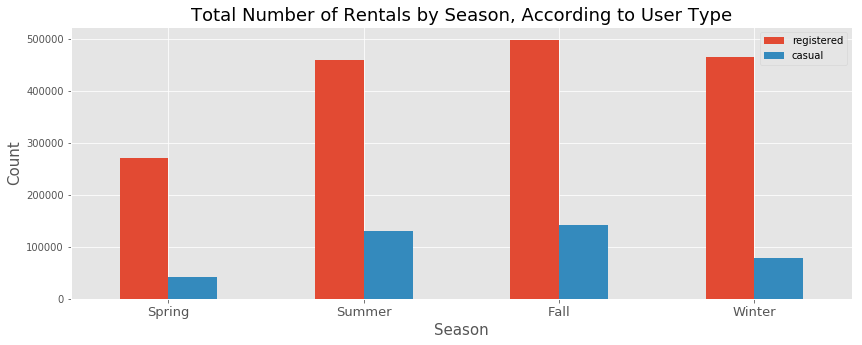

In [12]:
train[['season','registered','casual']].groupby('season').sum()\
    .plot(kind="bar", figsize=(14,5))
plt.xticks(rotation=0, size=13)
plt.ylabel("Count", size=15)
plt.xlabel("Season", size=15)
plt.title("Total Number of Rentals by Season, According to User Type", size=18)
plt.show()

This unexpected behavior (high number of rentals in the winter and low in spring) is explained by the unconventional month assignments to the seasons:

In [13]:
pd.crosstab(train.month, train.season)

season,Spring,Summer,Fall,Winter
month,,,,
January,884,0,0,0
February,901,0,0,0
March,901,0,0,0
April,0,909,0,0
May,0,912,0,0
June,0,912,0,0
July,0,0,912,0
August,0,0,912,0
September,0,0,909,0


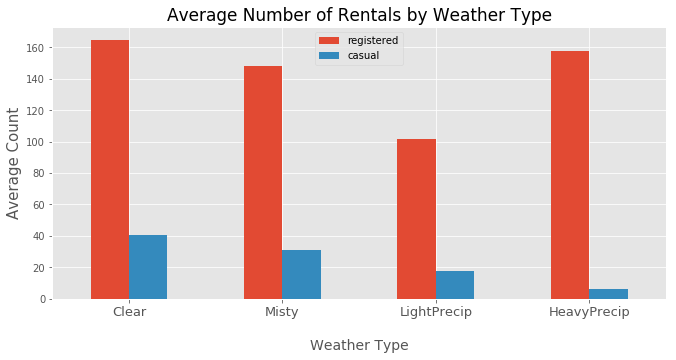

In [14]:
train[['weather','registered','casual']].groupby('weather').mean()\
    .plot(kind="bar", figsize=(11,5))
plt.xticks(rotation=0, size=13)
plt.xlabel("\nWeather Type", size=14)
plt.ylabel("Average Count", size=15)
plt.title("Average Number of Rentals by Weather Type", size=17)
plt.show()

In [15]:
# Only one row was labelled as having heavy precipitation - 
# It's probably best to combine with "Light Precipitation" so that 
# it doesn't bias the model.

train[train['weather']=="HeavyPrecip"]  

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,day_of_week,hour,month,year
5631,2012-01-09 18:00:00,Spring,0,1,HeavyPrecip,8.2,11.365,86,6.0032,6,158,164,Monday,18,January,2012


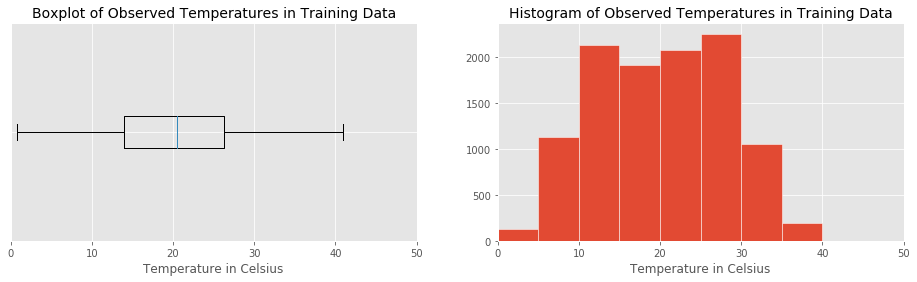

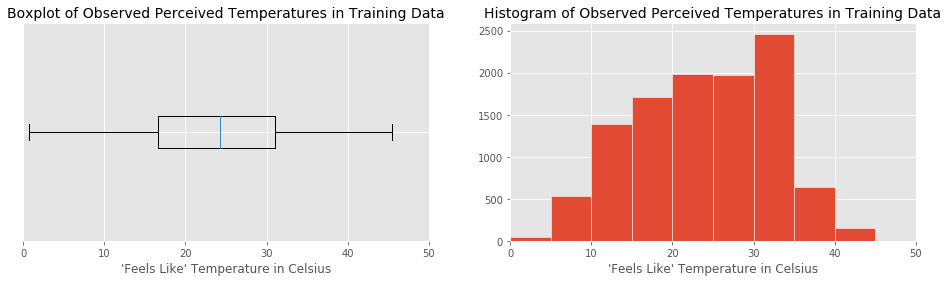

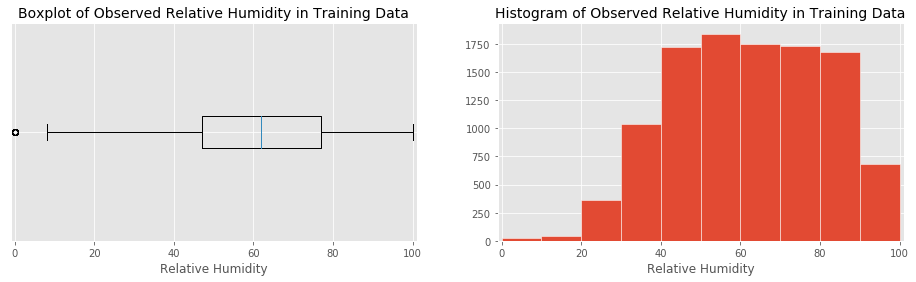

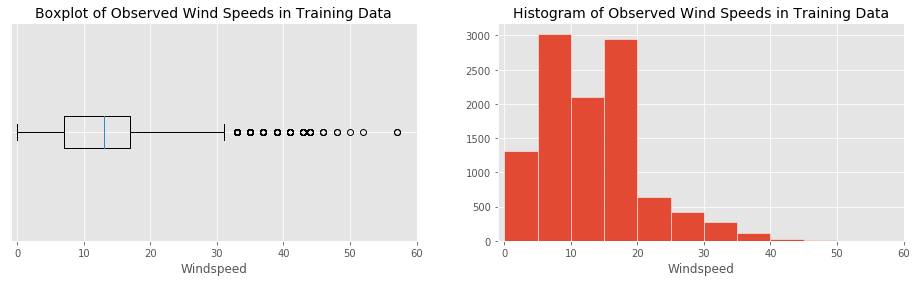

In [16]:
# Univariate analysis of numerical variables

# Temp
plt.subplots(nrows=1, ncols=2, figsize=(16,4))
plt.subplots_adjust(right=None, wspace=None, left=None)
plt.subplot(1,2,1)
plt.boxplot(train.temp, vert=False)
plt.title("Boxplot of Observed Temperatures in Training Data", size=14)
plt.xlabel("Temperature in Celsius", size=12)
plt.xlim(0,50)
plt.tick_params( axis='y', which="both", left="off", labelleft="off")
plt.subplot(1,2,2)
plt.hist(train.temp, edgecolor="white", bins=list(range(0,56,5)))
plt.title("Histogram of Observed Temperatures in Training Data", size=14)
plt.xlabel("Temperature in Celsius", size=12)
plt.xlim(0,50)
plt.show()

# Perceived Temp
plt.subplots(nrows=1, ncols=2, figsize=(16,4))
plt.subplots_adjust(right=None, wspace=None, left=None)
plt.subplot(1,2,1)
plt.boxplot(train.atemp, vert=False)
plt.title("Boxplot of Observed Perceived Temperatures in Training Data", size=14)
plt.xlabel("'Feels Like' Temperature in Celsius", size=12)
plt.xlim(0,50)
plt.tick_params( axis='y', which="both", left="off", labelleft="off")
plt.subplot(1,2,2)
plt.hist(train.atemp, edgecolor="white", bins=list(range(0,56,5)))
plt.title("Histogram of Observed Perceived Temperatures in Training Data", size=14)
plt.xlabel("'Feels Like' Temperature in Celsius", size=12)
plt.xlim(0,50)
plt.show()

# Humidity
plt.subplots(nrows=1, ncols=2, figsize=(16,4))
plt.subplots_adjust(right=None, wspace=None, left=None)
plt.subplot(1,2,1)
plt.boxplot(train.humidity, vert=False)
plt.title("Boxplot of Observed Relative Humidity in Training Data", size=14)
plt.xlabel("Relative Humidity", size=12)
plt.xlim(-1,101)
plt.tick_params( axis='y', which="both", left="off", labelleft="off")
plt.subplot(1,2,2)
plt.hist(train.humidity, edgecolor="white")
plt.title("Histogram of Observed Relative Humidity in Training Data", size=14)
plt.xlabel("Relative Humidity", size=12)
plt.xlim(-1,101)
plt.show()

# Windspeed
plt.subplots(nrows=1, ncols=2, figsize=(16,4))
plt.subplots_adjust(right=None, wspace=None, left=None)
plt.subplot(1,2,1)
plt.boxplot(train.windspeed, vert=False)
plt.title("Boxplot of Observed Wind Speeds in Training Data", size=14)
plt.xlabel("Windspeed", size=12)
plt.xlim(-1,60)
plt.tick_params( axis='y', which="both", left="off", labelleft="off")
plt.subplot(1,2,2)
plt.hist(train.windspeed, edgecolor="white", bins=list(range(0,61,5)))
plt.title("Histogram of Observed Wind Speeds in Training Data", size=14)
plt.xlabel("Windspeed", size=12)
plt.xlim(-1,60)
plt.show()

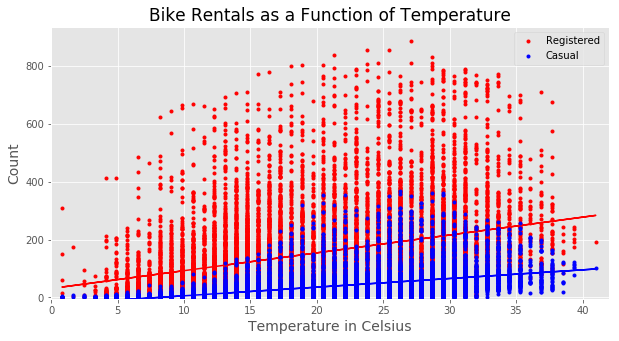

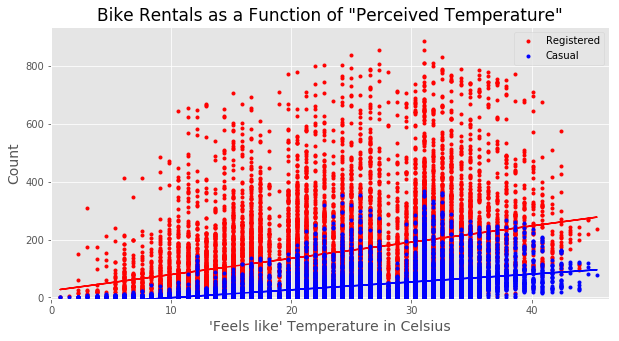

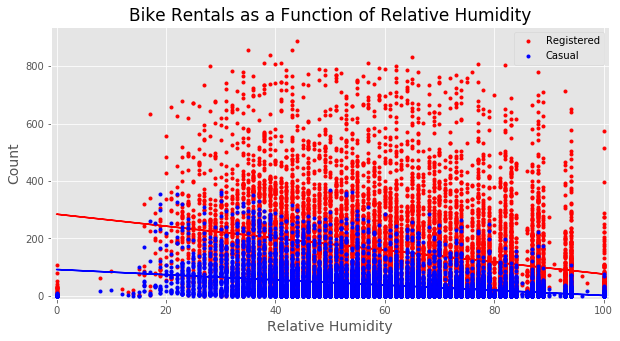

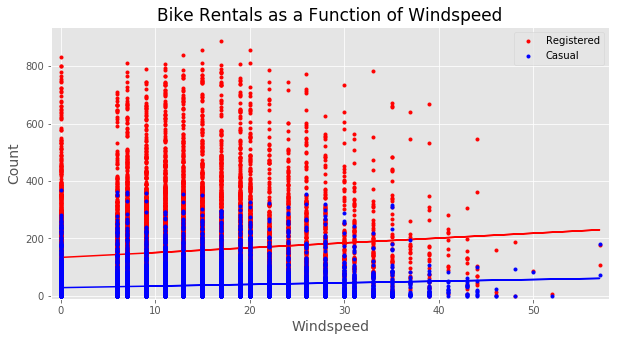

In [17]:
# Scatterplots

# Temperature
x = train.temp
y = train.registered
y2 = train.casual
m, b = np.polyfit(x, y, 1)
m2, b2 = np.polyfit(x, y2, 1)
plt.figure(figsize=(10,5))
plt.plot(x, y, '.', color='r', label="Registered")
plt.plot(x, m*x + b, '-', color='r', label='_nolegend_')
plt.plot(x, y2, '.', color='b', label="Casual")
plt.plot(x, m2*x + b2, '-', color='b', label='_nolegend_')
plt.xlabel("Temperature in Celsius", size=14)
plt.ylabel("Count", size=14)
plt.legend()
plt.title("Bike Rentals as a Function of Temperature", size=17)
plt.ylim([-5, y.max()+50])
plt.xlim([0, x.max()+1])
plt.show()

# Perceived Temp
x = train.atemp
y = train.registered
y2 = train.casual
m, b = np.polyfit(x, y, 1)
m2, b2 = np.polyfit(x, y2, 1)
plt.figure(figsize=(10,5))
plt.plot(x, y, '.', color='r', label="Registered")
plt.plot(x, m*x + b, '-', color='r', label='_nolegend_')
plt.plot(x, y2, '.', color='b', label="Casual")
plt.plot(x, m2*x + b2, '-', color='b', label='_nolegend_')
plt.xlabel("'Feels like' Temperature in Celsius", size=14)
plt.ylabel("Count", size=14)
plt.legend()
plt.title('Bike Rentals as a Function of "Perceived Temperature"', size=17)
plt.ylim([-5, y.max()+50])
plt.xlim([0, x.max()+1])
plt.show()

# Humidity
x = train.humidity
y = train.registered
y2 = train.casual
m, b = np.polyfit(x, y, 1)
m2, b2 = np.polyfit(x, y2, 1)
plt.figure(figsize=(10,5))
plt.plot(x, y, '.', color='r', label="Registered")
plt.plot(x, m*x + b, '-', color='r', label='_nolegend_')
plt.plot(x, y2, '.', color='b', label="Casual")
plt.plot(x, m2*x + b2, '-', color='b', label='_nolegend_')
plt.xlabel("Relative Humidity", size=14)
plt.ylabel("Count", size=14)
plt.legend()
plt.title('Bike Rentals as a Function of Relative Humidity', size=17)
plt.ylim([-10, y.max()+50])
plt.xlim([-1, x.max()+1])
plt.show()

# Windspeed
x = train.windspeed
y = train.registered
y2 = train.casual
m, b = np.polyfit(x, y, 1)
m2, b2 = np.polyfit(x, y2, 1)
plt.figure(figsize=(10,5))
plt.plot(x, y, '.', color='r', label="Registered")
plt.plot(x, m*x + b, '-', color='r', label='_nolegend_')
plt.plot(x, y2, '.', color='b', label="Casual")
plt.plot(x, m2*x + b2, '-', color='b', label='_nolegend_')
plt.xlabel("Windspeed", size=14)
plt.ylabel("Count", size=14)
plt.legend()
plt.title('Bike Rentals as a Function of Windspeed', size=17)
plt.ylim([-10, y.max()+50])
plt.xlim([-1, x.max()+1])
plt.show()

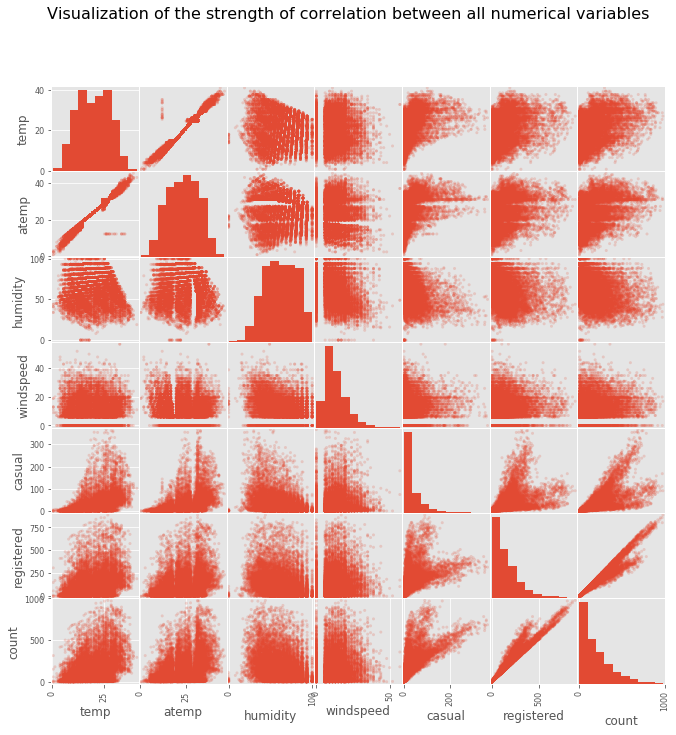

,temp,atemp,humidity,windspeed,casual,registered,count
temp,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454
atemp,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784
humidity,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371
windspeed,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369
casual,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414
registered,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948
count,0.394454,0.389784,-0.317371,0.101369,0.690414,0.970948,1.000000


In [18]:
# Show correlations between numerical variable:

num_data = train[train.columns[5:12]]
names = list(train[train.columns[5:12]])
correlations = num_data.corr()

scatter_matrix(num_data, alpha=0.2, figsize=(11, 11))
plt.suptitle('Visualization of the strength of correlation between all numerical variables',
          size=16)
plt.show()

# Show numerical values
correlations

We can see from the graphs and table above that there is a very high correlation between the variables "temp" and "atemp".  Additionally, temp is more strongly correlated with rental count than atemp is, so we should only include temp in our models.

## D. Baseline Model: Linear Regression

### i. Define Root Mean Squared Logarithmic Error Function

We use this metric to calculate dev set error, because Kaggle uses the same metric to score submissions for this challenge.

In [19]:
def rmsle(predictions, real):
    assert len(predictions) == len(real)
    return np.sqrt(np.mean(np.power(np.log1p(predictions) - np.log1p(real), 2)))

### ii. Feature Engineering

The EDA indicates that the hourly demand for bicycles varies depending on whether or not they day in question is a working day.  It also shows that the monthly demand for bicycles varies depending on the year.  We account for these relationships by adding interation terms for workingday and hour, and for month and year.

The EDA also indicates that the actual temperature (temp) and the "feels like' temperature (atemp) are heavily correlated, but that actual temperature is more heavily correlated with bike rental count then 'feels like' temperature is.  We will exclude the atemp feature from the linear model for that reason

In [20]:
def process_bike(bike_data):
    bike_data['dt']=pd.to_datetime(bike_data['datetime'])
    bike_data['day_of_week']=bike_data['dt'].apply(lambda x: x.strftime('%A'))
    bike_data['hour']=bike_data['dt'].apply(lambda x: x.strftime('%H'))
    bike_data['month']=bike_data['dt'].apply(lambda x: x.strftime('%B'))
    bike_data['day_of_month']=bike_data['dt'].apply(lambda x: int(x.strftime('%d')))
    bike_data['year']=bike_data['dt'].apply(lambda x: x.strftime('%Y'))

    #create season/weather variables
    #Note: light and heavy precipitation are coded identically in our model to prevent overfitting
    season={1:'Spring',2:'Summer',3:'Fall',4:'Winter'}
    bike_data['season_name']=bike_data['season'].map(season)
    weather={1: 'Clear', 2: 'Misty', 3: 'Precip', 4: 'Precip'}
    bike_data['weather_name']=bike_data['weather'].map(weather)
    
    # day_type
    bike_data["day_type"] = np.nan
    bike_data["day_type"][(bike_data["holiday"] == 0) & (bike_data["workingday"] == 0)] = "weekend"
    bike_data["day_type"][(bike_data["holiday"] == 1)] = "holiday"
    bike_data["day_type"][(bike_data["holiday"] == 0) & (bike_data["workingday"] == 1)] = "workday"

    # weekend
    bike_data["weekend"] = 0
    bike_data["weekend"][(bike_data["day_of_week"] == "Saturday") | (bike_data["day_of_week"] == "Sunday")] = 1


    #create dummy variables for month, hour, weekday, weather, and season
    month_dummy=pd.get_dummies(bike_data['month'])
    year_dummy=pd.get_dummies(bike_data['year'])
    hour_dummy=pd.get_dummies(bike_data['hour'])
    weekday_dummy=pd.get_dummies(bike_data['day_of_week'])
    weather_dummy=pd.get_dummies(bike_data['weather_name'])
    season_dummy=pd.get_dummies(bike_data['season_name'])
    daytype_dummy=pd.get_dummies(bike_data['day_type'])
    weekend_dummy=pd.get_dummies(bike_data['weekend'])
    
    #create dataframe with most relevant variables
    X_df=pd.concat([bike_data[['holiday','workingday','temp','humidity','windspeed']],year_dummy,month_dummy,hour_dummy,weather_dummy,season_dummy,daytype_dummy,weekend_dummy],axis=1,join='inner')

    #create interaction term for hour and workingday in X_df
    for i in hour_dummy.columns:
        X_df[i+' workingday']=X_df[i]*X_df['workingday']
        
    # Interaction terms for year and month in X_df
    for i in month_dummy.columns:
        X_df[i + '2011'] = X_df[i] * X_df['2011']

    for i in month_dummy.columns:
        X_df[i + '2012'] = X_df[i] * X_df['2012']
        
    return X_df

### iii. Create dev/training data using the pre-processing function in the feature engineering section

75% of the data is used for training the model, and the other 25% of the data is used in the development set.  We created three dependent variable frames: One for casual counts, one for registered counts, and one for total counts.

We generate separate predictions for casual and registered counts because the EDA demonstrates that they tend to follow different distributions

In [22]:
bike_data=pd.read_csv('train.csv')
X_df=process_bike(bike_data)

#define the dependent variables, i.e. the natural log of casual and registered counts
y_df_cas=bike_data['casual']
y_df_reg=bike_data['registered']
y_df_tot=bike_data['count']


#divide the data, and dependent variables into training and dev sets

shuffle = np.random.permutation(np.arange(X_df.shape[0]))
X, y_cas, y_reg,y_tot=X_df.iloc[shuffle],y_df_cas.iloc[shuffle],y_df_reg.iloc[shuffle],y_df_tot.iloc[shuffle]
X_train,y_train_cas,y_train_reg,y_train_tot=X.iloc[:8164],y_cas.iloc[:8164],y_reg.iloc[:8164],y_tot.iloc[:8164]
X_dev, y_dev_cas, y_dev_reg,y_dev_tot=X.iloc[8164:],y_cas.iloc[8164:],y_reg.iloc[8164:],y_tot.iloc[8164:]


#print the dimensions of each data frame

print 'train shape: ',X_train.shape
print 'dev shape: ',X_dev.shape
print 'casual training count shape: ',y_train_cas.shape
print 'casual dev count shape: ',y_dev_cas.shape

print 'registered training count shape: ',y_train_reg.shape
print 'registered dev count shape: ',y_dev_reg.shape

print 'total count train shape: ',y_train_tot.shape
print 'total count dev shape: ',y_dev_tot.shape

C:\Users\noahw\Anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\noahw\Anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\noahw\Anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\noahw\Anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel_launcher.py:24: Settin

train shape:  (8164, 103)
dev shape:  (2722, 103)
casual training count shape:  (8164L,)
casual dev count shape:  (2722L,)
registered training count shape:  (8164L,)
registered dev count shape:  (2722L,)
total count train shape:  (8164L,)
total count dev shape:  (2722L,)


### iv. Generate Predictions, Assess Performance on Dev Set

We set the "normalize" argument to True in order to reduce the skew in some of the continuous independent variables

In [23]:
from sklearn.linear_model import LinearRegression

#Fit casual rental model, normalize features
lm_cas = LinearRegression(normalize=True)
lm_cas.fit(X_train, np.log(y_train_cas+1))

#generate predictions for casual model, convert them from back from the the log scale to obtain the predicted counts.
lm_dev_preds_cas=np.exp(lm_cas.predict(X_dev))-1


#Fit registered rental model, normalize features
lm_reg = LinearRegression(normalize=True)
lm_reg.fit(X_train, np.log(y_train_reg+1))

##generate predictions for registered model, convert them from back from the the log scale to obtain the predicted counts.
lm_dev_preds_reg=np.exp(lm_reg.predict(X_dev))-1


#add predicted casual and registered counts to get the predicted total count
lm_dev_preds=lm_dev_preds_cas+lm_dev_preds_reg

lm_model_error=rmsle(lm_dev_preds,y_dev_tot.as_matrix())

print 'rmsle on dev data: ',lm_model_error

rmsle on dev data:  0.352298546147


Running one linear model with more features yields a fairly low rmsle

## E. Better Model: Regularized Linear Regression

We trained Ridge and Lasso Models on the model obtained in the previous section to see if regularization would improve the model performance.  We obtained the optimal alpha values for the casual and registered counts, and plotted dev set error against training set error to set if the models were overfitting the data

Ridge Results: 
	best alpha for casual counts:  0.001
	 best alpha for registered counts:  0.01
Lasso Results: 
	 best alpha for casual counts:  0.0001
	 best alpha for registered counts:  0.0001


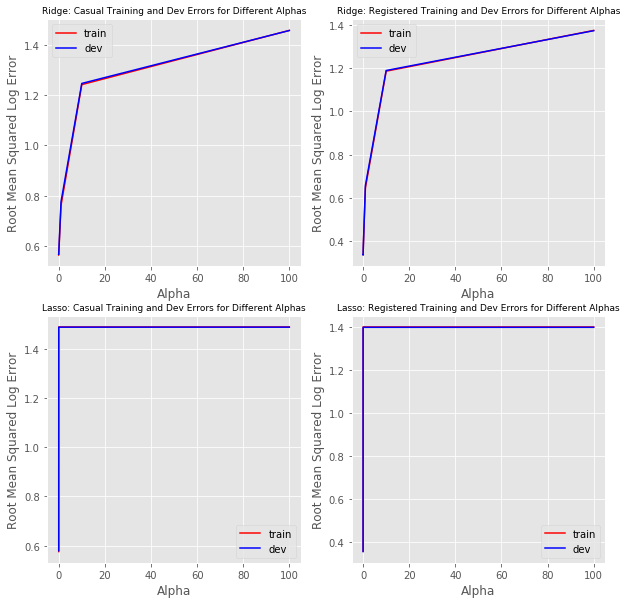

In [24]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

#define the range of alphas
alphas=[0.0001, 0.001, 0.01, 0.1, 1.0, 10., 100.]


ridge_train_errors_cas=[]
ridge_dev_errors_cas=[]
ridge_train_errors_reg=[]
ridge_dev_errors_reg=[]
lasso_train_errors_cas=[]
lasso_dev_errors_cas=[]
lasso_train_errors_reg=[]
lasso_dev_errors_reg=[]

#iterate over alphas, finding the best alphas for casual and registered in ridge and lasso regression
for alpha in alphas:
    
    #ridge regression on casual counts, calculate dev and training errors
    rm_cas=Ridge(alpha=alpha,normalize=True)
    rm_cas.fit(X_train,np.log(y_train_cas+1))
    
    train_predictions_cas=np.exp(rm_cas.predict(X_train))-1
    dev_predictions_cas=np.exp(rm_cas.predict(X_dev))-1
    
    train_error_cas=rmsle(train_predictions_cas,y_train_cas.as_matrix())
    dev_error_cas=rmsle(dev_predictions_cas,y_dev_cas.as_matrix())    
    ridge_train_errors_cas.append(train_error_cas)
    ridge_dev_errors_cas.append(dev_error_cas)
    
    #ridge regression on registered counts, calculate dev and training errors
    rm_reg=Ridge(alpha=alpha,normalize=True)
    rm_reg.fit(X_train,np.log(y_train_reg+1))
    
    train_predictions_reg=np.exp(rm_reg.predict(X_train))-1
    dev_predictions_reg=np.exp(rm_reg.predict(X_dev))-1
    
    train_error_reg=rmsle(train_predictions_reg,y_train_reg.as_matrix())
    dev_error_reg=rmsle(dev_predictions_reg,y_dev_reg.as_matrix())    
    ridge_train_errors_reg.append(train_error_reg)
    ridge_dev_errors_reg.append(dev_error_reg)

    #lasso regression on casual counts, calculate dev and training errors
    las_cas=Lasso(alpha=alpha,normalize=True)
    las_cas.fit(X_train,np.log(y_train_cas+1))
    
    train_predictions_cas=np.exp(las_cas.predict(X_train))-1
    dev_predictions_cas=np.exp(las_cas.predict(X_dev))-1
    
    train_error_cas=rmsle(train_predictions_cas,y_train_cas.as_matrix())
    dev_error_cas=rmsle(dev_predictions_cas,y_dev_cas.as_matrix())    
    lasso_train_errors_cas.append(train_error_cas)
    lasso_dev_errors_cas.append(dev_error_cas)
    
    
    #lasso regression on registered counts, calculate dev and training errors
    las_reg=Lasso(alpha=alpha,normalize=True)
    las_reg.fit(X_train,np.log(y_train_reg+1))
    
    train_predictions_reg=np.exp(las_reg.predict(X_train))-1
    dev_predictions_reg=np.exp(las_reg.predict(X_dev))-1
    
    train_error_reg=rmsle(train_predictions_reg,y_train_reg.as_matrix())
    dev_error_reg=rmsle(dev_predictions_reg,y_dev_reg.as_matrix())    
    lasso_train_errors_reg.append(train_error_reg)
    lasso_dev_errors_reg.append(dev_error_reg)


#define best alpha values    
best_ridge_alpha_cas=[alpha for _,alpha in sorted(zip(ridge_dev_errors_cas,alphas))][0]
best_ridge_alpha_reg=[alpha for _,alpha in sorted(zip(ridge_dev_errors_reg,alphas))][0]
best_lasso_alpha_cas=[alpha for _,alpha in sorted(zip(lasso_dev_errors_cas,alphas))][0]
best_lasso_alpha_reg=[alpha for _,alpha in sorted(zip(lasso_dev_errors_reg,alphas))][0]

print 'Ridge Results: '
print '\tbest alpha for casual counts: ',best_ridge_alpha_cas
print '\t best alpha for registered counts: ',best_ridge_alpha_reg

print 'Lasso Results: '
print '\t best alpha for casual counts: ',best_lasso_alpha_cas
print '\t best alpha for registered counts: ',best_lasso_alpha_reg

    
plt.figure(figsize=(10, 10))
    
plt.subplot(2,2,1)
plt.xlabel('Alpha')
plt.ylabel('Root Mean Squared Log Error')
plt.title('Ridge: Casual Training and Dev Errors for Different Alphas',size=9)
plt.plot(alphas,ridge_train_errors_cas,color='r',label='train')
plt.plot(alphas,ridge_dev_errors_cas,color='b',label='dev')
plt.legend()

plt.subplot(2,2,2)
plt.xlabel('Alpha')
plt.ylabel('Root Mean Squared Log Error')
plt.title('Ridge: Registered Training and Dev Errors for Different Alphas',size=9)
plt.plot(alphas,ridge_train_errors_reg,color='r',label='train')
plt.plot(alphas,ridge_dev_errors_reg,color='b',label='dev')
plt.legend()

plt.subplot(2,2,3)
plt.xlabel('Alpha')
plt.ylabel('Root Mean Squared Log Error')
plt.title('Lasso: Casual Training and Dev Errors for Different Alphas',size=9)
plt.plot(alphas,lasso_train_errors_cas,color='r',label='train')
plt.plot(alphas,lasso_dev_errors_cas,color='b',label='dev')
plt.legend()

plt.subplot(2,2,4)
plt.xlabel('Alpha')
plt.ylabel('Root Mean Squared Log Error')
plt.title('Lasso: Registered Training and Dev Errors for Different Alphas',size=9)
plt.plot(alphas,lasso_train_errors_reg,color='r',label='train')
plt.plot(alphas,lasso_dev_errors_reg,color='b',label='dev')
plt.legend()


The RMSLE doesn't differ signficantly between the training and dev sets for different values of alpha.  This indicates that the linear model doesn't significantly overfit the data.

### vi. Improved Performance

Now, we assess whether Ridge or Lasso regressions using the optimal values of alpha yield better results than the linear regression did.

In [25]:
#predictions for optimal ridge alphas
optimal_ridge_cas=Ridge(normalize=True,alpha=best_ridge_alpha_cas)
optimal_ridge_cas.fit(X_train, np.log(y_train_cas+1))
dev_predictions_cas=np.exp(optimal_ridge_cas.predict(X_dev))-1

optimal_ridge_reg=Ridge(normalize=True,alpha=best_ridge_alpha_reg)
optimal_ridge_reg.fit(X_train, np.log(y_train_reg+1))
dev_predictions_reg=np.exp(optimal_ridge_reg.predict(X_dev))-1

dev_predictions=dev_predictions_cas+dev_predictions_reg
best_ridge_rmsle=rmsle(dev_predictions,y_dev_tot.as_matrix())
print 'rmsle on dev data for optimal Ridge Regression: ',best_ridge_rmsle

#predictions for optimal lasso alphas
optimal_lasso_cas=Lasso(normalize=True,alpha=best_lasso_alpha_cas)
optimal_lasso_cas.fit(X_train, np.log(y_train_cas+1))
dev_predictions_cas=np.exp(optimal_lasso_cas.predict(X_dev))-1

optimal_lasso_reg=Lasso(normalize=True,alpha=best_lasso_alpha_reg)
optimal_lasso_reg.fit(X_train, np.log(y_train_reg+1))
dev_predictions_reg=np.exp(optimal_lasso_reg.predict(X_dev))-1

dev_predictions=dev_predictions_cas+dev_predictions_reg

best_lasso_rmsle=rmsle(dev_predictions,y_dev_tot.as_matrix())
print 'rmsle on dev data for optimal Lasso Regression: ',best_lasso_rmsle

rmsle on dev data for optimal Ridge Regression:  0.350932623469
rmsle on dev data for optimal Lasso Regression:  0.367472478206


The error for ridge regression is slightly smaller than the error for linear regression was, but the difference isn't particularly notable

## F. Best Approach: Random Forest Regresion

We obtained the most accurate, parsimonious model by training a Random Forest Regressor on the training data.  This model generates predictions by taking a vote of different prediction trees, which are generated by sampling different features and observations

### i. Initial Random Forest Regression

This Random Forest regression uses all of the features that were defined for the linear model

In [26]:
from  sklearn.ensemble import RandomForestRegressor

dev_errors=[]
train_errors=[]
errors_estimators=[]

#tune model with respect to n-estimators
n_estimators=np.arange(10,100,10)

for n in n_estimators:
    
    #generate predictions for casual counts
    rf_cas=RandomForestRegressor(n_estimators=n)
    rf_cas.fit(X_train,np.log(y_train_cas+1))
    rf_preds_cas=np.exp(rf_cas.predict(X_dev))-1
    
    rf_train_preds_cas=np.exp(rf_cas.predict(X_train))-1

    #generate predictions for registered counts
    rf_reg=RandomForestRegressor(n_estimators=n)
    rf_reg.fit(X_train,np.log(y_train_reg+1))
    rf_preds_reg=np.exp(rf_reg.predict(X_dev))-1
    
    rf_train_preds_reg=np.exp(rf_reg.predict(X_train))-1

    dev_predictions=rf_preds_cas+rf_preds_reg
    train_predictions=rf_train_preds_cas+rf_train_preds_reg
    
    #record dev set and train set error
    rf_rmsle=rmsle(dev_predictions,y_dev_tot.as_matrix())
    rf_train_rmsle=rmsle(train_predictions,y_train_tot.as_matrix())
    print 'n_estimators: ',n
    print 'dev set rmsle for Random Forest Regression: ',rf_rmsle
    dev_errors.append(rf_rmsle)
    train_errors.append(rf_train_rmsle)
    errors_estimators.append((n,rf_rmsle))

best_estimator=sorted(errors_estimators,key=lambda k: k[1])
print '\nbest n_estimators: ',best_estimator[0][0]
print 'best n_estimators RMSLE: ',best_estimator[0][1]

n_estimators:  10
dev set rmsle for Random Forest Regression:  0.351533977315
n_estimators:  20
dev set rmsle for Random Forest Regression:  0.346551403416
n_estimators:  30
dev set rmsle for Random Forest Regression:  0.340693213299
n_estimators:  40
dev set rmsle for Random Forest Regression:  0.337878685284
n_estimators:  50
dev set rmsle for Random Forest Regression:  0.340754596753
n_estimators:  60
dev set rmsle for Random Forest Regression:  0.339471724978
n_estimators:  70
dev set rmsle for Random Forest Regression:  0.340900894883
n_estimators:  80
dev set rmsle for Random Forest Regression:  0.336599867569
n_estimators:  90
dev set rmsle for Random Forest Regression:  0.338774748667

best n_estimators:  80
best n_estimators RMSLE:  0.336599867569


For certain values of n_estimators, the random forest regression outperforms the linear and ridge regressions.

### iii. Check for Overfitting

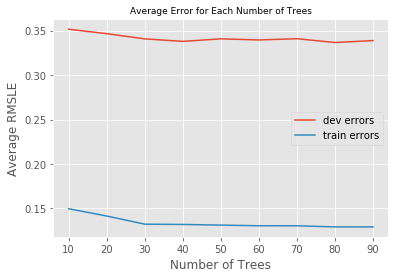

In [27]:
num_trees=np.arange(10,100,10)

plt.xlabel('Number of Trees')
plt.ylabel('Average RMSLE')
plt.title('Average Error for Each Number of Trees',size=9)
plt.plot(num_trees,dev_errors,label='dev errors')
plt.plot(num_trees,train_errors,label='train errors')
plt.legend()

The large discrepancy between the train set errors and the dev set errors indicates that the current selection of features overfits the data in the context of the RandomForestRegression model

### iv More parsimonious data processing function

To account for the overfitting in the RandomForestRegression model, this feature engineering function drops the interaction terms.

In [28]:
def revised_process_bike(bike_data):
    bike_data['dt']=pd.to_datetime(bike_data['datetime'])
    bike_data['day_of_week']=bike_data['dt'].apply(lambda x: x.strftime('%A'))
    bike_data['hour']=bike_data['dt'].apply(lambda x: x.strftime('%H'))
    bike_data['month']=bike_data['dt'].apply(lambda x: x.strftime('%B'))
    bike_data['year']=bike_data['dt'].apply(lambda x: x.strftime('%Y'))

    #create season/weather variables
    season={1:'Spring',2:'Summer',3:'Fall',4:'Winter'}
    bike_data['season_name']=bike_data['season'].map(season)
    weather={1: 'Clear', 2: 'Misty', 3: 'Precip', 4: 'Precip'}
    bike_data['weather_name']=bike_data['weather'].map(weather)



    #create dummy variables for month, hour, weekday, weather, and season
    month_dummy=pd.get_dummies(bike_data['month'])
    year_dummy=pd.get_dummies(bike_data['year'])
    hour_dummy=pd.get_dummies(bike_data['hour'])
    weekday_dummy=pd.get_dummies(bike_data['day_of_week'])
    weather_dummy=pd.get_dummies(bike_data['weather_name'])
    season_dummy=pd.get_dummies(bike_data['season_name'])

    #create dataframe with most relevant variables
    X_df=pd.concat([bike_data[['holiday','workingday','temp','humidity','windspeed']],year_dummy,month_dummy,hour_dummy,weather_dummy,season_dummy],axis=1,join='inner')

    return X_df

In [29]:
bike_data=pd.read_csv('train.csv')
X_df=revised_process_bike(bike_data)

#define the dependent variables, i.e. the natural log of casual and registered counts
y_df_cas=bike_data['casual']
y_df_reg=bike_data['registered']
y_df_tot=bike_data['count']


#divide the data, and dependent variables into training and dev sets

shuffle = np.random.permutation(np.arange(X_df.shape[0]))
X, y_cas, y_reg,y_tot=X_df.iloc[shuffle],y_df_cas.iloc[shuffle],y_df_reg.iloc[shuffle],y_df_tot.iloc[shuffle]
X_train,y_train_cas,y_train_reg,y_train_tot=X.iloc[:8164],y_cas.iloc[:8164],y_reg.iloc[:8164],y_tot.iloc[:8164]
X_dev, y_dev_cas, y_dev_reg,y_dev_tot=X.iloc[8164:],y_cas.iloc[8164:],y_reg.iloc[8164:],y_tot.iloc[8164:]


#print the dimensions of each data frame

print 'train shape: ',X_train.shape
print 'dev shape: ',X_dev.shape
print 'casual training count shape: ',y_train_cas.shape
print 'casual dev count shape: ',y_dev_cas.shape

print 'registered training count shape: ',y_train_reg.shape
print 'registered dev count shape: ',y_dev_reg.shape

print 'total count train shape: ',y_train_tot.shape
print 'total count dev shape: ',y_dev_tot.shape

train shape:  (8164, 50)
dev shape:  (2722, 50)
casual training count shape:  (8164L,)
casual dev count shape:  (2722L,)
registered training count shape:  (8164L,)
registered dev count shape:  (2722L,)
total count train shape:  (8164L,)
total count dev shape:  (2722L,)


### v. Revised RandomForestRegression

Another random forest regression is performed using the revised feature set

In [30]:
dev_errors=[]
train_errors=[]

errors_estimators=[]

n_estimators=np.arange(10,100,10)

for n in n_estimators:
    rf_cas=RandomForestRegressor(n_estimators=n)
    rf_cas.fit(X_train,np.log(y_train_cas+1))
    rf_preds_cas=np.exp(rf_cas.predict(X_dev))-1
    
    rf_train_preds_cas=np.exp(rf_cas.predict(X_train))-1

    rf_reg=RandomForestRegressor(n_estimators=n)
    rf_reg.fit(X_train,np.log(y_train_reg+1))
    rf_preds_reg=np.exp(rf_reg.predict(X_dev))-1
    
    rf_train_preds_reg=np.exp(rf_reg.predict(X_train))-1

    dev_predictions=rf_preds_cas+rf_preds_reg
    train_predictions=rf_train_preds_cas+rf_train_preds_reg
    
    rf_rmsle=rmsle(dev_predictions,y_dev_tot.as_matrix())
    rf_train_rmsle=rmsle(train_predictions,y_train_tot.as_matrix())
    print 'n_estimators: ',n
    print 'rmsle for Random Forest Regression: ',rf_rmsle
    dev_errors.append(rf_rmsle)
    train_errors.append(rf_train_rmsle)
    errors_estimators.append((n,rf_rmsle))

best_estimator=sorted(errors_estimators,key=lambda k: k[1])
print '\nbest n_estimators: ',best_estimator[0][0]
print 'best n_estimators RMSLE: ',best_estimator[0][1]

n_estimators:  10
rmsle for Random Forest Regression:  0.352973910609
n_estimators:  20
rmsle for Random Forest Regression:  0.344179673604
n_estimators:  30
rmsle for Random Forest Regression:  0.338200385581
n_estimators:  40
rmsle for Random Forest Regression:  0.336727284117
n_estimators:  50
rmsle for Random Forest Regression:  0.335117533088
n_estimators:  60
rmsle for Random Forest Regression:  0.33827145324
n_estimators:  70
rmsle for Random Forest Regression:  0.335418565187
n_estimators:  80
rmsle for Random Forest Regression:  0.337200939701
n_estimators:  90
rmsle for Random Forest Regression:  0.335551874471

best n_estimators:  50
best n_estimators RMSLE:  0.335117533088


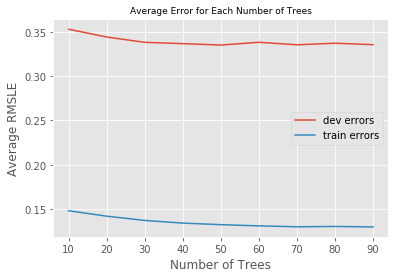

In [31]:
num_trees=np.arange(10,100,10)

plt.xlabel('Number of Trees')
plt.ylabel('Average RMSLE')
plt.title('Average Error for Each Number of Trees',size=9)
plt.plot(num_trees,dev_errors,label='dev errors')
plt.plot(num_trees,train_errors,label='train errors')
plt.legend()

Although this revised RandomForestRegression doesn't significantly improve the dev set RMSLE or solve the problem of overfitting, it acheives the same error level with fewer features and can be considered to be a better model because it's more parsimonious

## G. Generate Predictions on Test Set, Submit to Kaggle

In [32]:
#read in test data
bike_test=pd.read_csv('test.csv')

#process bike data using feature engineering function
bike_test_df=revised_process_bike(bike_test)

print bike_test_df.shape

#generate predictions for test set using best n_estimators
rf_test=RandomForestRegressor(n_estimators=best_estimator[0][0])
rf_test.fit(X_train,np.log(y_train_reg+1))
rf_preds=np.exp(rf_test.predict(bike_test_df))-1

#create submission file for test predictions
submission=pd.DataFrame({'datetime': bike_test['dt'],'count': rf_preds.tolist()} )
submission.to_csv('rf_preds.csv',columns=['datetime','count'],header=True,index=False)


(6493, 50)


The kaggle score on the test data was 0.48

## H. Overall Results

Based on the experiments conducted using the linear model and the random forest regression, the best results were obtained from a random forest regression The performance of each model is summarized below:

In [33]:
print 'Linear Model: \n', 
print '\tbest dev set error: ',lm_model_error

print '\n'

print 'Ridge Regression: \n',
print '\tbest alpha value for casual counts: ',best_ridge_alpha_cas
print '\tbest alpha value for registered counts: ',best_ridge_alpha_reg
print '\t best dev set error: ',best_ridge_rmsle

print '\n'

print 'Random Forest Regression: \n',
print '\t best n_estimators: ',best_estimator[0][0]
print '\t best dev set error: ',best_estimator[0][1]




Linear Model: 
	best dev set error:  0.352298546147


Ridge Regression: 
	best alpha value for casual counts:  0.001
	best alpha value for registered counts:  0.01
	 best dev set error:  0.350932623469


Random Forest Regression: 
	 best n_estimators:  50
	 best dev set error:  0.335117533088


## I. Conclusion

As mentioned above, our best models producing the lowest Root Mean Squared Logarithmic Error for predictions on the development data were Random Forest Regression (~0.34), Ridge Regression (~0.36), and Unregularized Linear Regression (RMSLE ~0.36), 

Aside from these, other models we attempted did not produce nearly as good of predictions (K-Nearest Neighbors, Multinomial Naive Bayes, and Principal Component Analysis, for example).  Our final submission to Kaggle curiously resulted in a higher RMSLE than we obtained using predictions on the dev set.  

One possible explanation as to why this was the case may be because of the nature by which the training and test sets were partitioned (by Kaggle).  Kaggle took all hours from days 1-19 of every month to create the training set, and the test set was then comprised of all data from days 20 onward from every month.  We chose to randomly select observations (hours) in Kaggle's training set to create our development data set, so this data should have been very much like other data in the training set.

However, it may be the case, for instance, that the final days of each month experience slightly different rental patterns than the first 19 days, for whatever reason--or that the final 9-12 days of each month behave more like the first days of the following month rather than previous days in the same month.  Continual improvements to our model could take that into account, then, by adding a month to the test set before making a prediction on it.  

Other ways we might improve our Linear model include creating more features from the variables we already have, by binning them in new ways or creating interaction variables.  This proved to be successful for us already in reducing our prediction error, so we believe with even more feature engineering we could get even better results.  By contrast, we could probably improve the Random Forest Regression model by removing features in order to reduce the apparent gap between the training error and the dev set error.

Overall, we learned the importance of feature engineering, fine-tuning parameters and testing many different machine learning models in order to arrive at our best results.